## Decision Trees for multiclassification

### Import Data

In [1]:
#! pip install xgboost
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

/Users/dimitrisbouris/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Read all the CSV files

In [3]:
%%time
df= pd.read_csv('flights_fact.csv',low_memory=False)

CPU times: user 9.26 s, sys: 17.9 s, total: 27.1 s
Wall time: 34.5 s


In [4]:
aircraft_dim= pd.read_csv('aircraft_dim.csv')
aircraft_dim = aircraft_dim.rename(columns={'N-Number': 'TAIL_NUMBER'})

In [7]:
date_dim=pd.read_csv('date_dim.csv')

In [8]:
arrivalAirport_dim=pd.read_csv('arrivalAirport_dim.csv')
arrivalAirport_dim = arrivalAirport_dim.rename(columns={'IATA_CODE': 'DESTINATION_AIRPORT'})

In [9]:
departureAirport_dim=pd.read_csv('departureAirport_dim.csv')
departureAirport_dim = departureAirport_dim.rename(columns={'IATA_CODE': 'ORIGIN_AIRPORT'})

In [10]:
departureTime_dim=pd.read_csv('departureTime_dim.csv')

In [11]:
arrivalTime_dim=pd.read_csv('arrivalTime_dim.csv')

* Merge the fact table with the dimension tables

In [12]:
%%time

df=pd.merge(df,aircraft_dim, on='TAIL_NUMBER', how='inner')
df=pd.merge(df,date_dim, on='dateKey', how='inner')
df=pd.merge(df,arrivalAirport_dim, on='DESTINATION_AIRPORT', how='inner')
df=pd.merge(df,departureAirport_dim, on='ORIGIN_AIRPORT', how='inner')
df=pd.merge(df,departureTime_dim,on='scheduledDeparture_key',how='inner')
df=pd.merge(df,arrivalTime_dim,on='scheduledArrival_key',how='inner')

CPU times: user 10.7 s, sys: 5.12 s, total: 15.8 s
Wall time: 16.9 s


* Create a new method called get_value that creates a new column called 'class' and assigns the values 0,1,2 to the classes early,on_time,delayed respectively if those classes appear to be 1 in the initial dataset.

In [13]:
%%time 

def get_value(df):
    if df['early'] == 1:
        return 0
    elif df['on_time'] == 1:
        return 1
    elif df['delayed'] == 1:
        return 2

df['class'] = df.apply(lambda df: get_value(df), axis=1)


CPU times: user 26.5 s, sys: 9.08 s, total: 35.6 s
Wall time: 43.6 s


### Print merged Dataframe 

In [14]:
df

,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,scheduledDeparture_key,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,CITY_y,STATE_y,COUNTRY_y,LATITUDE_y,LONGITUDE_y,Hour_x,Minute_x,Hour_y,Minute_y,class
0,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15,...,Anchorage,AK,USA,61.17432,-149.99619,0,5,4,30,0
1,AS,98,N764AS,ANC,SEA,5,2353.0,-12.0,18.0,11,...,Anchorage,AK,USA,61.17432,-149.99619,0,5,4,30,0
2,AS,98,N317AS,ANC,SEA,5,41.0,36.0,13.0,54,...,Anchorage,AK,USA,61.17432,-149.99619,0,5,4,30,2
3,AS,98,N520AS,ANC,SEA,5,2358.0,-7.0,8.0,6,...,Anchorage,AK,USA,61.17432,-149.99619,0,5,4,30,0
4,AS,98,N453AS,ANC,SEA,5,2354.0,-11.0,8.0,2,...,Anchorage,AK,USA,61.17432,-149.99619,0,5,4,30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919448,UA,2010,N497UA,ORD,TPA,14,10.0,-4.0,25.0,35,...,Chicago,IL,USA,41.97960,-87.90446,0,14,3,55,1
3919449,UA,2010,N414UA,ORD,TPA,14,10.0,-4.0,17.0,27,...,Chicago,IL,USA,41.97960,-87.90446,0,14,3,55,0
3919450,UA,512,N24212,DEN,SEA,14,16.0,2.0,18.0,34,...,Denver,CO,USA,39.85841,-104.66700,0,14,2,20,0
3919451,EV,6074,N12195,ORD,SAV,22,48.0,26.0,12.0,100,...,Chicago,IL,USA,41.97960,-87.90446,0,22,3,32,2


### Remove unwanted columns

In [15]:
df=df.drop(['YEAR','FLIGHT_NUMBER','TAIL_NUMBER','TAXI_OUT','WHEELS_OFF','ELAPSED_TIME', 'AIR_TIME','WHEELS_ON',
            'TAXI_IN','CANCELLATION_REASON','ARRIVAL_DELAY','early','on_time','delayed',
              'new_delay','DIVERTED','CANCELLED','AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY',
                    'WEATHER_DELAY','YEAR','LATE_AIRCRAFT_DELAY','num_engines','num_passengers','Year Mfr','TypeAcft',
           'type','AircraftMFRModelCode','COUNTRY_x','COUNTRY_y'], axis=1)


In [16]:
df.isna().sum()

AIRLINE                      0
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
scheduledDeparture_key       0
DEPARTURE_TIME               0
DEPARTURE_DELAY              0
SCHEDULED_TIME               0
DISTANCE                     0
scheduledArrival_key         0
ARRIVAL_TIME                 0
dateKey                      0
Unnamed: 0                   0
mfr_name                     0
model_name                   0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
fullDate                     0
month_name                   0
day_name                     0
AIRPORT_x                    0
CITY_x                       0
STATE_x                      0
LATITUDE_x                4132
LONGITUDE_x               4132
AIRPORT_y                    0
CITY_y                       0
STATE_y                      0
LATITUDE_y                4053
LONGITUDE_y               4053
Hour_x                       0
Minute_x                     0
Hour_y  

In [17]:
df.dropna(subset=['LATITUDE_x','LATITUDE_y','LONGITUDE_x','LONGITUDE_y'], inplace=True)

In [18]:
df.isna().sum()

AIRLINE                   0
ORIGIN_AIRPORT            0
DESTINATION_AIRPORT       0
scheduledDeparture_key    0
DEPARTURE_TIME            0
DEPARTURE_DELAY           0
SCHEDULED_TIME            0
DISTANCE                  0
scheduledArrival_key      0
ARRIVAL_TIME              0
dateKey                   0
Unnamed: 0                0
mfr_name                  0
model_name                0
MONTH                     0
DAY                       0
DAY_OF_WEEK               0
fullDate                  0
month_name                0
day_name                  0
AIRPORT_x                 0
CITY_x                    0
STATE_x                   0
LATITUDE_x                0
LONGITUDE_x               0
AIRPORT_y                 0
CITY_y                    0
STATE_y                   0
LATITUDE_y                0
LONGITUDE_y               0
Hour_x                    0
Minute_x                  0
Hour_y                    0
Minute_y                  0
class                     0
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3911268 entries, 0 to 3919452
Data columns (total 35 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   AIRLINE                 object 
 1   ORIGIN_AIRPORT          object 
 2   DESTINATION_AIRPORT     object 
 3   scheduledDeparture_key  int64  
 4   DEPARTURE_TIME          float64
 5   DEPARTURE_DELAY         float64
 6   SCHEDULED_TIME          float64
 7   DISTANCE                int64  
 8   scheduledArrival_key    int64  
 9   ARRIVAL_TIME            float64
 10  dateKey                 int64  
 11  Unnamed: 0              int64  
 12  mfr_name                object 
 13  model_name              object 
 14  MONTH                   int64  
 15  DAY                     int64  
 16  DAY_OF_WEEK             int64  
 17  fullDate                object 
 18  month_name              object 
 19  day_name                object 
 20  AIRPORT_x               object 
 21  CITY_x                  object 

### Perform Correlation Statistic Test

<AxesSubplot:>

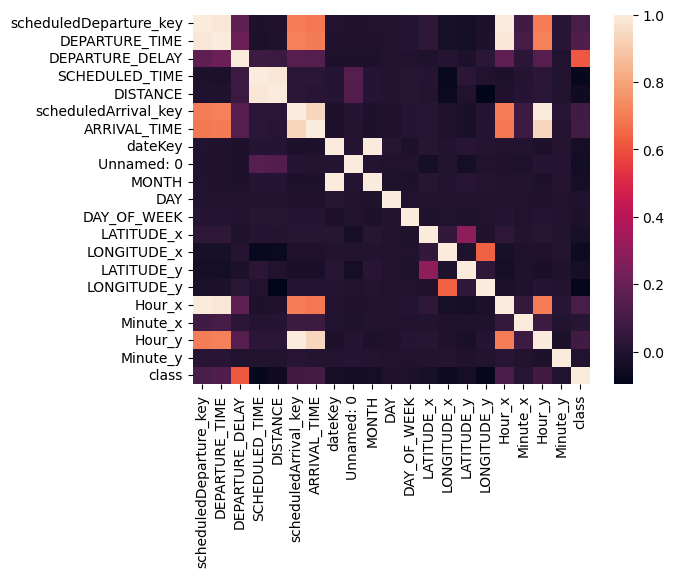

In [20]:
sns.heatmap(df.corr())

In [15]:
#columns=['FLIGHT_NUMBER','TAIL_NUMBER','scheduledDeparture_key','DEPARTURE_DELAY','TAXI_OUT','WHEELS_OFF',
               #'AIR_TIME','WHEELS_ON','TAXI_IN','scheduledArrival_key','ARRIVAL_DELAY','early','on_time','delayed',
              #'new_delay','class'])
# Select the target variable
y = df['class']

# Select the feature columns
X = df.drop(columns=['class'])

# Compute the correlation matrix
corr = X.corrwith(y)

# Sort the correlations in descending order
corr_sorted = corr.sort_values(ascending=False)

# Print the sorted correlations
corr_sorted



DEPARTURE_DELAY           0.615048
DEPARTURE_TIME            0.133851
scheduledDeparture_key    0.114499
Hour_x                    0.114257
ARRIVAL_TIME              0.097204
Hour_y                    0.091624
scheduledArrival_key      0.091609
Minute_x                  0.014690
Minute_y                 -0.000238
DAY                      -0.005247
DAY_OF_WEEK              -0.014753
LATITUDE_x               -0.027424
MONTH                    -0.034027
dateKey                  -0.034159
LATITUDE_y               -0.036029
DISTANCE                 -0.053450
LONGITUDE_x              -0.060567
SCHEDULED_TIME           -0.078487
LONGITUDE_y              -0.084342
dtype: float64

In [21]:
df

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,scheduledDeparture_key,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,scheduledArrival_key,ARRIVAL_TIME,...,AIRPORT_y,CITY_y,STATE_y,LATITUDE_y,LONGITUDE_y,Hour_x,Minute_x,Hour_y,Minute_y,class
0,AS,ANC,SEA,5,2354.0,-11.0,205.0,1448,430,408.0,...,Ted Stevens Anchorage International Airport,Anchorage,AK,61.17432,-149.99619,0,5,4,30,0
1,AS,ANC,SEA,5,2353.0,-12.0,205.0,1448,430,403.0,...,Ted Stevens Anchorage International Airport,Anchorage,AK,61.17432,-149.99619,0,5,4,30,0
2,AS,ANC,SEA,5,41.0,36.0,205.0,1448,430,449.0,...,Ted Stevens Anchorage International Airport,Anchorage,AK,61.17432,-149.99619,0,5,4,30,2
3,AS,ANC,SEA,5,2358.0,-7.0,205.0,1448,430,405.0,...,Ted Stevens Anchorage International Airport,Anchorage,AK,61.17432,-149.99619,0,5,4,30,0
4,AS,ANC,SEA,5,2354.0,-11.0,205.0,1448,430,417.0,...,Ted Stevens Anchorage International Airport,Anchorage,AK,61.17432,-149.99619,0,5,4,30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919448,UA,ORD,TPA,14,10.0,-4.0,161.0,1012,355,346.0,...,Chicago O'Hare International Airport,Chicago,IL,41.97960,-87.90446,0,14,3,55,1
3919449,UA,ORD,TPA,14,10.0,-4.0,161.0,1012,355,343.0,...,Chicago O'Hare International Airport,Chicago,IL,41.97960,-87.90446,0,14,3,55,0
3919450,UA,DEN,SEA,14,16.0,2.0,186.0,1024,220,209.0,...,Denver International Airport,Denver,CO,39.85841,-104.66700,0,14,2,20,0
3919451,EV,ORD,SAV,22,48.0,26.0,130.0,773,332,349.0,...,Chicago O'Hare International Airport,Chicago,IL,41.97960,-87.90446,0,22,3,32,2


In [24]:

# Multiply the values in the "hour" column by 60]
df["hour_minutes_dep"] = df["Hour_x"] * 60

# Add the resulting values to the values in the "minute" column
df["total_minutes_dep"] = df["hour_minutes_dep"] + df["Minute_x"]

# Drop the original "hour" and "minute" columns
df = df.drop(columns=["Hour_x", "Minute_x"])

In [25]:

# Multiply the values in the "hour" column by 60]
df["hour_minutes_arr"] = df["Hour_y"] * 60

# Add the resulting values to the values in the "minute" column
df["total_minutes_arr"] = df["hour_minutes_arr"] + df["Minute_y"]

# Drop the original "hour" and "minute" columns
df = df.drop(columns=["Hour_y", "Minute_y"])

In [26]:
df

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,scheduledDeparture_key,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,scheduledArrival_key,ARRIVAL_TIME,...,AIRPORT_y,CITY_y,STATE_y,LATITUDE_y,LONGITUDE_y,class,hour_minutes_dep,total_minutes_dep,hour_minutes_arr,total_minutes_arr
0,AS,ANC,SEA,5,2354.0,-11.0,205.0,1448,430,408.0,...,Ted Stevens Anchorage International Airport,Anchorage,AK,61.17432,-149.99619,0,0,5,240,270
1,AS,ANC,SEA,5,2353.0,-12.0,205.0,1448,430,403.0,...,Ted Stevens Anchorage International Airport,Anchorage,AK,61.17432,-149.99619,0,0,5,240,270
2,AS,ANC,SEA,5,41.0,36.0,205.0,1448,430,449.0,...,Ted Stevens Anchorage International Airport,Anchorage,AK,61.17432,-149.99619,2,0,5,240,270
3,AS,ANC,SEA,5,2358.0,-7.0,205.0,1448,430,405.0,...,Ted Stevens Anchorage International Airport,Anchorage,AK,61.17432,-149.99619,0,0,5,240,270
4,AS,ANC,SEA,5,2354.0,-11.0,205.0,1448,430,417.0,...,Ted Stevens Anchorage International Airport,Anchorage,AK,61.17432,-149.99619,0,0,5,240,270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919448,UA,ORD,TPA,14,10.0,-4.0,161.0,1012,355,346.0,...,Chicago O'Hare International Airport,Chicago,IL,41.97960,-87.90446,1,0,14,180,235
3919449,UA,ORD,TPA,14,10.0,-4.0,161.0,1012,355,343.0,...,Chicago O'Hare International Airport,Chicago,IL,41.97960,-87.90446,0,0,14,180,235
3919450,UA,DEN,SEA,14,16.0,2.0,186.0,1024,220,209.0,...,Denver International Airport,Denver,CO,39.85841,-104.66700,0,0,14,120,140
3919451,EV,ORD,SAV,22,48.0,26.0,130.0,773,332,349.0,...,Chicago O'Hare International Airport,Chicago,IL,41.97960,-87.90446,2,0,22,180,212


* Use the OneHotEncoder class from the sklearn.preprocessing module to perform one-hot encoding on the categorical column.

In [28]:
%%time
dummies = pd.get_dummies(df['AIRLINE'])
dummies

CPU times: user 328 ms, sys: 36.2 ms, total: 364 ms
Wall time: 389 ms


,AA,AS,B6,DL,EV,F9,HA,MQ,NK,OO,UA,US,VX,WN
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919448,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3919449,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3919450,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3919451,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [29]:
df=pd.concat([df, dummies], axis=1)
df = df.drop(['AIRLINE', 'ORIGIN_AIRPORT','DESTINATION_AIRPORT'], axis=1)

In [30]:
df.columns

Index(['scheduledDeparture_key', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
       'SCHEDULED_TIME', 'DISTANCE', 'scheduledArrival_key', 'ARRIVAL_TIME',
       'dateKey', 'Unnamed: 0', 'mfr_name', 'model_name', 'MONTH', 'DAY',
       'DAY_OF_WEEK', 'fullDate', 'month_name', 'day_name', 'AIRPORT_x',
       'CITY_x', 'STATE_x', 'LATITUDE_x', 'LONGITUDE_x', 'AIRPORT_y', 'CITY_y',
       'STATE_y', 'LATITUDE_y', 'LONGITUDE_y', 'class', 'hour_minutes_dep',
       'total_minutes_dep', 'hour_minutes_arr', 'total_minutes_arr', 'AA',
       'AS', 'B6', 'DL', 'EV', 'F9', 'HA', 'MQ', 'NK', 'OO', 'UA', 'US', 'VX',
       'WN'],
      dtype='object')

In [32]:
#columns=['FLIGHT_NUMBER','TAIL_NUMBER','scheduledDeparture_key','DEPARTURE_DELAY','TAXI_OUT','WHEELS_OFF',
               #'AIR_TIME','WHEELS_ON','TAXI_IN','scheduledArrival_key','ARRIVAL_DELAY','early','on_time','delayed',
              #'new_delay','class'])
# Select the target variable
y = df['class']

# Select the feature columns
X = df.drop(columns=['class'])

# Compute the correlation matrix
corr = X.corrwith(y)

# Sort the correlations in descending order
corr_sorted = corr.sort_values(ascending=False,key=abs)

# Print the sorted correlations
corr_sorted.head(20)


DEPARTURE_DELAY           0.615048
DEPARTURE_TIME            0.133851
total_minutes_dep         0.114571
scheduledDeparture_key    0.114499
hour_minutes_dep          0.114257
ARRIVAL_TIME              0.097204
hour_minutes_arr          0.091624
scheduledArrival_key      0.091609
total_minutes_arr         0.091538
LONGITUDE_y              -0.084342
DL                       -0.083963
SCHEDULED_TIME           -0.078487
WN                        0.061951
LONGITUDE_x              -0.060567
DISTANCE                 -0.053450
HA                        0.049249
Unnamed: 0               -0.042697
LATITUDE_y               -0.036029
UA                       -0.034942
dateKey                  -0.034159
dtype: float64

* Info and analysis of data

In [33]:
df.isnull().any().value_counts()

False    46
dtype: int64

In [34]:
df.columns

Index(['scheduledDeparture_key', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
       'SCHEDULED_TIME', 'DISTANCE', 'scheduledArrival_key', 'ARRIVAL_TIME',
       'dateKey', 'Unnamed: 0', 'mfr_name', 'model_name', 'MONTH', 'DAY',
       'DAY_OF_WEEK', 'fullDate', 'month_name', 'day_name', 'AIRPORT_x',
       'CITY_x', 'STATE_x', 'LATITUDE_x', 'LONGITUDE_x', 'AIRPORT_y', 'CITY_y',
       'STATE_y', 'LATITUDE_y', 'LONGITUDE_y', 'class', 'hour_minutes_dep',
       'total_minutes_dep', 'hour_minutes_arr', 'total_minutes_arr', 'AA',
       'AS', 'B6', 'DL', 'EV', 'F9', 'HA', 'MQ', 'NK', 'OO', 'UA', 'US', 'VX',
       'WN'],
      dtype='object')

In [35]:
df=df.drop(['model_name','fullDate','month_name','day_name','AIRPORT_x','CITY_x','STATE_x',
              'AIRPORT_y','CITY_y','STATE_y','Unnamed: 0','scheduledDeparture_key','scheduledArrival_key',
           'DAY_OF_WEEK','fullDate','month_name','day_name','mfr_name'],axis=1)

In [ ]:
# Select only the numerical columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.drop('class')

# Store the data from the numerical columns in a NumPy array
X = ex_df[numeric_columns].values

# Create the scaler
scaler = StandardScaler()

# Fit the scaler to the data
scaler.fit(X)

# Scale the data
X_scaled = scaler.transform(X)

# Update the data in the DataFrame
ex_df[numeric_columns] = X_scaled

In [36]:
df.columns

Index(['DEPARTURE_TIME', 'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'DISTANCE',
       'ARRIVAL_TIME', 'dateKey', 'MONTH', 'DAY', 'LATITUDE_x', 'LONGITUDE_x',
       'LATITUDE_y', 'LONGITUDE_y', 'class', 'hour_minutes_dep',
       'total_minutes_dep', 'hour_minutes_arr', 'total_minutes_arr', 'AA',
       'AS', 'B6', 'DL', 'EV', 'F9', 'HA', 'MQ', 'NK', 'OO', 'UA', 'US', 'VX',
       'WN'],
      dtype='object')

### Decision Trees

* Assign to x all the features that we will use for prediction and assign to y the class feature that we want to predict

In [107]:
x= df.drop(['DEPARTURE_TIME','class','ARRIVAL_TIME','DAY','MONTH'],axis=1)  
y= df['class']

In [108]:
x.columns

Index(['DEPARTURE_DELAY', 'SCHEDULED_TIME', 'DISTANCE', 'dateKey',
       'LATITUDE_x', 'LONGITUDE_x', 'LATITUDE_y', 'LONGITUDE_y',
       'hour_minutes_dep', 'total_minutes_dep', 'hour_minutes_arr',
       'total_minutes_arr', 'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'HA', 'MQ',
       'NK', 'OO', 'UA', 'US', 'VX', 'WN'],
      dtype='object')

* Split to trainning and testing set with a 80:20 ratio

In [109]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.25,random_state=0)  

* Create a DecisionTreeClassifier based on the entropy

In [110]:
%%time
#Entropy
classifier= DecisionTreeClassifier(criterion='entropy', random_state=0)  
model=classifier.fit(x_train, y_train)  

CPU times: user 31.5 s, sys: 743 ms, total: 32.3 s
Wall time: 33.5 s


* Predicting the test set result based on the Entropy

In [111]:
#Predicting the test set result (Entropy)
y_pred= classifier.predict(x_test)

In [112]:
print(classifier.tree_.max_depth)

61


 Create a DecisionTreeClassifier based on the gini index

In [103]:
%%time
#Gini
classifier1= DecisionTreeClassifier(criterion='gini', random_state=0)  
model1=classifier1.fit(x_train, y_train) 

CPU times: user 30.3 s, sys: 831 ms, total: 31.1 s
Wall time: 31.9 s


* Predicting the test set result based on the gini index

In [104]:
#Predicting the test set result (Gini)
y_pred1= classifier1.predict(x_test)

### Print the classification report and interpret the results

In [113]:
# Print the classification report (Entropy)
report = classification_report(y_test, y_pred)
print(report)

# Print the F1 score
f1 = f1_score(y_test, y_pred, average="micro")
print("F1 score:", f1)

              precision    recall  f1-score   support

           0       0.59      0.60      0.60    344006
           1       0.65      0.64      0.64    495479
           2       0.63      0.64      0.63    138332

    accuracy                           0.63    977817
   macro avg       0.62      0.63      0.62    977817
weighted avg       0.63      0.63      0.63    977817

F1 score: 0.6251353780922198


In [106]:
# Print the classification report(Gini)
report = classification_report(y_test, y_pred1)
print(report)

# Print the F1 score
f1 = f1_score(y_test, y_pred1, average="micro")
print("F1 score:", f1)

              precision    recall  f1-score   support

           0       0.58      0.59      0.59    344006
           1       0.64      0.63      0.64    495479
           2       0.59      0.58      0.59    138332

    accuracy                           0.61    977817
   macro avg       0.61      0.60      0.60    977817
weighted avg       0.61      0.61      0.61    977817

F1 score: 0.6127168989698482


### XGBOOST

In [90]:
# Remove duplicate columns
ex_df = df.loc[:, ~df.columns.duplicated()]

In [91]:
ex_df = ex_df.sample(frac=0.4, random_state=42)

In [92]:
x= ex_df.drop(['DEPARTURE_DELAY','class','ARRIVAL_TIME','DAY','MONTH'],axis=1)  
y= ex_df['class']

In [93]:
x

,DEPARTURE_TIME,SCHEDULED_TIME,DISTANCE,dateKey,LATITUDE_x,LONGITUDE_x,LATITUDE_y,LONGITUDE_y,hour_minutes_dep,total_minutes_dep,...,EV,F9,HA,MQ,NK,OO,UA,US,VX,WN
3899694,1945.0,157.0,1014,20150514,36.12448,-86.67818,39.85841,-104.66700,1140,1190,...,1,0,0,0,0,0,0,0,0,0
937222,840.0,265.0,1728,20150410,32.73356,-117.18966,41.78598,-87.75242,480,520,...,0,0,0,0,0,0,0,0,0,1
625541,756.0,192.0,1217,20150607,32.89595,-97.03720,39.17540,-76.66820,480,480,...,0,0,0,0,1,0,0,0,0,0
724048,1244.0,161.0,859,20150304,33.64044,-84.42694,41.93887,-72.68323,720,764,...,0,0,0,0,0,0,0,0,0,0
160835,934.0,330.0,2173,20150426,36.08036,-115.15233,26.07258,-80.15275,540,580,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985106,857.0,109.0,440,20151103,38.74769,-90.35999,42.21206,-83.34884,480,532,...,0,0,0,0,0,0,0,0,0,0
614334,851.0,85.0,460,20150215,39.29761,-94.71391,32.84711,-96.85177,540,540,...,0,0,0,0,0,0,0,0,0,1
982259,907.0,88.0,386,20150419,46.77411,-100.74672,44.88055,-93.21692,540,551,...,0,0,0,0,0,1,0,0,0,0
3139777,2035.0,131.0,666,20150716,33.64044,-84.42694,39.87195,-75.24114,1200,1225,...,0,0,0,0,0,0,0,0,0,0


In [94]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.25,random_state=0)  

In [95]:
%%time
# Create the classifier
clf = XGBClassifier(max_depth=25,n_estimators=100)

# Fit the classifier to the training data
clf.fit(x_train, y_train)

# Make predictions on the test data
predictions = clf.predict(x_test)


/Users/dimitrisbouris/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/dimitrisbouris/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:10:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 1h 12min 39s, sys: 3min 37s, total: 1h 16min 17s
Wall time: 12min 1s


In [96]:
# Print the classification report(Gini)
report = classification_report(y_test, predictions)
print(report)

# Print the F1 score
f1 = f1_score(y_test, predictions, average="micro")
print("F1 score:", f1)

              precision    recall  f1-score   support

           0       0.66      0.63      0.64    137429
           1       0.68      0.73      0.70    198416
           2       0.77      0.63      0.69     55282

    accuracy                           0.68    391127
   macro avg       0.70      0.66      0.68    391127
weighted avg       0.68      0.68      0.68    391127

F1 score: 0.6807967744492198


In [ ]:
# Calculate the confusion matrix for the test set
confusion_matrix = confusion_matrix(y_test, predictions)

# Print the confusion matrix
print(confusion_matrix)

In [ ]:
# Plot the feature importance scores, excluding the first two columns
xgb.plot_importance(clf,importance_type='weight', max_num_features=11)

### Evaluate the model 

In [ ]:
# Evaluate the model on the test data
test_score = clf.score(x_test, y_test)

# Evaluate the model on the training data
train_score = clf.score(x_train, y_train)

# Print the scores
print(f"Test score: {test_score:.3f}")
print(f"Train score: {train_score:.3f}")